# Changing `@op`s and managing versions
It should be easy to change your code and have the storage respond in a correct
way (e.g., recompute a call **only** when the logic behind it has changed).
`mandala` provides the following mechanisms to do that:

- **automatic per-call dependency tracking**: every `@op` call records the
functions it called along the way. This allows the `storage` to automatically
know, given some inputs, whether a past call for these inputs can be reused 
given the current state of the code. This is a very fine-grained notion of
reuse.
- **marking changes as breaking vs non-breaking**: when a change to an `@op` or
its dependencies is detected, you can choose to mark it as breaking the calls that depend on it
or not. However, **breaking changes are generally more fool-proof**; see [caveats of non-breaking changes](#caveats-of-marking-changes-as-non-breaking).
- **content-based versioning**: the current state of the codebase uniquely
determines the version each `@op` is in. There are no arbitrary names attached
to versions. The versions for each `@op` can be inspected in a `git`-like data
structure.

## Enabling and configuring versioning
Passing a value to the `deps_path` parameter of the `Storage` class enables
dependency tracking and versioning. This means that any time a memoized function
*actually executes* (instead of reusing a past call's results), it keeps track
of the functions and global variables it accesses along the way. 

Usually, the functions we want to track are limited to user-defined ones (you
typically don't want to track changes in installed libraries!):

- Setting `deps_path` to `"__main__"` will only look for dependencies `f`
defined in the current interactive session or process (as determined by
`f.__module__`).
- Setting it to a folder will only look for dependencies defined in this folder.

In [1]:
from mandala.imports import Storage, op, track

storage = Storage(deps_path='__main__')

## The `@track` decorator
The most efficient and reliable implementation of dependency tracking currently
requires you to explicitly put `@track` on non-memoized functions and classes
you want to track. This limitation may be lifted in the future, but at the cost
of more magic (i.e., automatically applying the decorator to functions in the
current local scope that originate in given paths).

The alternative (experimental) decorator implementation is based on
`sys.settrace`. Limitations are described in this [blog
post](https://amakelov.github.io/blog/deps/#syssettrace))

## Examining the captured versions
Let's run a small ML pipeline, where we optionally apply scaling to the data,
introducing a non-`@op` dependency for some of the calls:

In [2]:
from sklearn.datasets import load_digits
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

N_CLASS = 10

@track # to track a non-memoized function as a dependency
def scale_data(X):
    return StandardScaler(with_mean=True, with_std=False).fit_transform(X)

@op
def load_data():
    X, y = load_digits(n_class=N_CLASS, return_X_y=True)
    return X, y

@op
def train_model(X, y, scale=False):
    if scale:
        X = scale_data(X)
    return LogisticRegression(max_iter=1000, solver='liblinear').fit(X, y)

@op
def eval_model(model, X, y, scale=False):
    if scale:
        X = scale_data(X)
    return model.score(X, y)

with storage:
    X, y = load_data()
    for scale in [False, True]:
        model = train_model(X, y, scale=scale)
        acc = eval_model(model, X, y, scale=scale)

Now `train_model` and `eval_model` will each have two versions - one that
depends on `scale_data` and one that doesn't. You can confirm this by calling
e.g. `storage.versions(train_model)`:

In [3]:
storage.versions(train_model)

╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│ ### Dependencies for version of function train_model from module __main__                                       │
│ ### content_version_id=db93a1e9c60fb37868575845a7afe47d                                                         │
│ ### semantic_version_id=2acaa8919ddd4b5d8846f1f2d15bc971                                                        │
│                                                                                                                 │
│ ################################################################################                                │
│ ### IN MODULE "__main__"                                                                                        │
│ ################################################################################                                │
│                                                                                                                 │
│ @op                                                                                                             │
│ def train_model(X, y, scale=False):                                                                             │
│     if scale:                                                                                                   │
│         X = scale_data(X)                                                                                       │
│     return LogisticRegression(max_iter=1000, solver='liblinear').fit(X, y)                                      │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯
╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│ ### Dependencies for version of function train_model from module __main__                                       │
│ ### content_version_id=2717c55fbbbb60442535a8dea0c81f67                                                         │
│ ### semantic_version_id=4674057d19bbf217687dd9dabe01df36                                                        │
│                                                                                                                 │
│ ################################################################################                                │
│ ### IN MODULE "__main__"                                                                                        │
│ ################################################################################                                │
│                                                                                                                 │
│ @track # to track a non-memoized function as a dependency                                                       │
│ def scale_data(X):                                                                                              │
│     return StandardScaler(with_mean=True, with_std=False).fit_transform(X)                                      │
│                                                                                                                 │
│ @op                                                                                                             │
│ def train_model(X, y, scale=False):                                                                             │
│     if scale:                                                                                                   │
│         X = scale_data(X)                                                                                       │
│     return LogisticRegression(max_iter=1000, solver='liblinear').fit(X, y)                                      │
│                                                       

## Making changes and sorting them into breaking and non-breaking
Now suppose we make some changes and re-run:

- we change the value of the global variable `N_CLASS`;
- we change the code of `scale_data` in a semantically meaningful (i.e.,
breaking) way
- we change the code of `eval_model` in a "cosmetic" way that can be considered
non-breaking.

When entering the `storage` block, the storage will detect the changes in
the tracked components, and for each change will present you with the functions
affected:

- `N_CLASS` is a dependency for `load_data`;
- `scale_data` is a dependency for the calls to `train_model` and `eval_model`
  which had `scale=True`;
- `eval_model` is a dependency for itself.

In [4]:
### simulate user input non-interactively
from unittest.mock import patch

def mock_input(prompts):
    it = iter(prompts)
    def mock_input_func(*args):
        return next(it)
    return mock_input_func

In [5]:
N_CLASS = 5

@track
def scale_data(X):
    return StandardScaler(with_mean=True, with_std=True).fit_transform(X)

@op
def eval_model(model, X, y, scale=False):
    if scale:
        X = scale_data(X)
    return round(model.score(X, y), 2)

answers = ['y', 'n', 'y']

with patch('builtins.input', mock_input(answers)):
    with storage:
        X, y = load_data()
        for scale in [False, True]:
            model = train_model(X, y, scale=scale)
            acc = eval_model(model, X, y, scale=scale)

CHANGE DETECTED in N_CLASS from module __main__
Dependent components:
  Version of "load_data" from module "__main__" (content: 426c4c8c56d7c0d6374095c7d4a4974f, semantic: 7d0732b9bfb31e5e2211e0122651a624)


╭───────────────────────────────────────────────────── Diff ──────────────────────────────────────────────────────╮
│   1 -10                                                                                                         │
│   2 +5                                                                                                          │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

Does this change require recomputation of dependent calls?
Answer: [y]es/[n]o/[a]bort 
You answered: "y"
CHANGE DETECTED in eval_model from module __main__
Dependent components:
  Version of "eval_model" from module "__main__" (content: 955b2a683de8dacf624047c0e020140a, semantic: c847d6dc3f23c176e6c8bf9e7006576a)
  Version of "eval_model" from module "__main__" (content: 5bdcd6ffc4888990d8922aa85795198d, semantic: 4e1d702e9797ebba156831294de46425)


╭───────────────────────────────────────────────────── Diff ──────────────────────────────────────────────────────╮
│   1      if scale:                                                                                              │
│   2          X = scale_data(X)                                                                                  │
│   3 -    return model.score(X, y)                                                                               │
│   4 +    return round(model.score(X, y), 2)                                                                     │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

Does this change require recomputation of dependent calls?
Answer: [y]es/[n]o/[a]bort 
You answered: "n"
CHANGE DETECTED in scale_data from module __main__
Dependent components:
  Version of "train_model" from module "__main__" (content: 2717c55fbbbb60442535a8dea0c81f67, semantic: 4674057d19bbf217687dd9dabe01df36)
  Version of "eval_model" from module "__main__" (content: 5bdcd6ffc4888990d8922aa85795198d, semantic: 4e1d702e9797ebba156831294de46425)


╭───────────────────────────────────────────────────── Diff ──────────────────────────────────────────────────────╮
│   1 -@track # to track a non-memoized function as a dependency                                                  │
│   2 +@track                                                                                                     │
│   3  def scale_data(X):                                                                                         │
│   4 -    return StandardScaler(with_mean=True, with_std=False).fit_transform(X)                                 │
│   5 +    return StandardScaler(with_mean=True, with_std=True).fit_transform(X)                                  │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

Does this change require recomputation of dependent calls?
Answer: [y]es/[n]o/[a]bort 
You answered: "y"


When a change is detected, the UI:

- shows the diffs in each function,
- gives you a list of which `@op`s' versions are affected by each change
- lets you choose if the change is breaking or non-breaking

We can check what happened by constructing a computation frame:

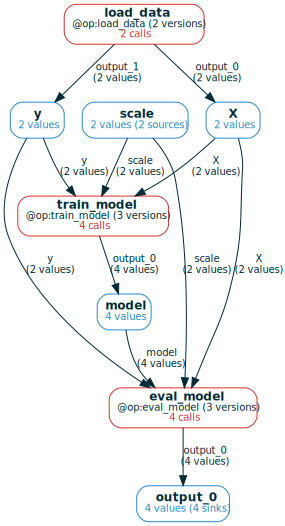

In [6]:
cf = storage.cf(eval_model).expand_all()
cf.draw(verbose=True)

We see that `load_data` has two versions in use, whereas `train_model` and
`eval_model` both have three. Which ones? Again, call `versions` to find out.
For example, with `eval_model`, we have 4 different content versions, that 
overall span 3 semantically different versions:

In [7]:
storage.versions(eval_model)

╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│ ### Dependencies for version of function eval_model from module __main__                                        │
│ ### content_version_id=955b2a683de8dacf624047c0e020140a                                                         │
│ ### semantic_version_id=c847d6dc3f23c176e6c8bf9e7006576a                                                        │
│                                                                                                                 │
│ ################################################################################                                │
│ ### IN MODULE "__main__"                                                                                        │
│ ################################################################################                                │
│                                                                                                                 │
│ @op                                                                                                             │
│ def eval_model(model, X, y, scale=False):                                                                       │
│     if scale:                                                                                                   │
│         X = scale_data(X)                                                                                       │
│     return model.score(X, y)                                                                                    │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯
╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│ ### Dependencies for version of function eval_model from module __main__                                        │
│ ### content_version_id=5bdcd6ffc4888990d8922aa85795198d                                                         │
│ ### semantic_version_id=4e1d702e9797ebba156831294de46425                                                        │
│                                                                                                                 │
│ ################################################################################                                │
│ ### IN MODULE "__main__"                                                                                        │
│ ################################################################################                                │
│                                                                                                                 │
│ @op                                                                                                             │
│ def eval_model(model, X, y, scale=False):                                                                       │
│     if scale:                                                                                                   │
│         X = scale_data(X)                                                                                       │
│     return model.score(X, y)                                                                                    │
│                                                                                                                 │
│ @track # to track a non-memoized function as a dependency                                                       │
│ def scale_data(X):                                                                                              │
│     return StandardScaler(with_mean=True, with_std=False).fit_transform(X)                                      │
│                                                       

## Additional notes

### So what really is a version of an `@op`?
A **version** for an `@op` is a collection of

- (hashes of) the source code of functions and methods
- (hashes of) values of global variables

at the time when a call to this `@op` was executed. Even if you don't change
anything in the code, a single function can have multiple versions if it invokes
different dependencies for different calls. 

### Going back in time
Since the versioning system is content-based, simply restoring an old state of
the code makes the storage automatically recognize which "world" it's in, and
which calls are memoized in this world.

### Caveats of marking changes as non-breaking
The main motivation for allowing non-breaking changes is to maintain the storage
when doing routine code improvements (refactoring, comments, logging).

**However**, non-semantic changes should be applied with care. Apart from being
prone to errors (you wrongly conclude that a change has no effect on semantics
when it does), they can also introduce **invisible dependencies**: suppose you
factor a function out of some dependency and mark the change non-semantic. Then
the newly extracted function may in reality be a dependency of the existing
calls, but this goes unnoticed by the system. Consequently, changes in this 
dependency may go unnoticed by the versioning algorithm.